<a href="https://colab.research.google.com/github/soyyoon/ML_project/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 모델 학습을 위한 데이터 전처리

In [1]:
import numpy as np
import os
import time
from tqdm import tqdm
from skimage.feature import hog
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_auc_score

# 4개의 모델 임포트
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = '/content/drive/MyDrive/ML_Project'
SAVE_PATH_TRAIN = os.path.join(BASE_DIR, 'colored_mnist_train_80k.npz')
SAVE_PATH_VAL = os.path.join(BASE_DIR, 'colored_mnist_val_80k.npz')

NUM_CLASSES_DIGIT = 10  # 숫자 (0~9)
NUM_CLASSES_COLOR = 7   # 색상 (무지개 7색)

# 학습 데이터 로드
print("학습 데이터 로딩 중...")
train_data = np.load(SAVE_PATH_TRAIN)
X_train_color = train_data['images']
y_train_digit = train_data['labels_digit']
y_train_fg = train_data['labels_fg']
y_train_bg = train_data['labels_bg']

# 테스트 데이터 로드
print("테스트 데이터 로딩 중...")
val_data = np.load(SAVE_PATH_VAL)
X_val_color = val_data['images']
y_val_digit = val_data['labels_digit']
y_val_fg = val_data['labels_fg']
y_val_bg = val_data['labels_bg']

print(f"\n원본 학습 데이터 Shape: {X_train_color.shape}")


# --- 2. 데이터 전처리 ---
# 2-1. 색상 분류용 (Color 3D -> 1D Flatten)
X_train_flat_color = X_train_color.reshape(X_train_color.shape[0], -1)
X_val_flat_color = X_val_color.reshape(X_val_color.shape[0], -1)

print(f"색상 분류용 데이터 (Color): {X_train_flat_color.shape}")

Mounted at /content/drive
학습 데이터 로딩 중...
테스트 데이터 로딩 중...

원본 학습 데이터 Shape: (80000, 28, 28, 3)
색상 분류용 데이터 (Color): (80000, 2352)


## 그레이스케일 없이 모델 학습

In [2]:
print("\n--- 3종 모델 학습 시작 (총 9개) ---")

# 학습할 모델과 데이터를 '작업 목록'으로 정의
training_jobs = [
    # 1. RandomForest
    ("RandomForest - Digit", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1), X_train_flat_color, y_train_digit),
    ("RandomForest - FG Color", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1), X_train_flat_color, y_train_fg),
    ("RandomForest - BG Color", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1), X_train_flat_color, y_train_bg),

    # 2. XGBoost
    ("XGBoost - Digit", xgb.XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multi:softmax', eval_metric='mlogloss', num_class=NUM_CLASSES_DIGIT), X_train_flat_color, y_train_digit),
    ("XGBoost - FG Color", xgb.XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multi:softmax', eval_metric='mlogloss', num_class=NUM_CLASSES_COLOR), X_train_flat_color, y_train_fg),
    ("XGBoost - BG Color", xgb.XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multi:softmax', eval_metric='mlogloss', num_class=NUM_CLASSES_COLOR), X_train_flat_color, y_train_bg),

    # 3. LightGBM
    ("LightGBM - Digit", lgb.LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multiclass', num_class=NUM_CLASSES_DIGIT, verbosity=-1), X_train_flat_color, y_train_digit),
    ("LightGBM - FG Color", lgb.LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multiclass', num_class=NUM_CLASSES_COLOR, verbosity=-1), X_train_flat_color, y_train_fg),
    ("LightGBM - BG Color", lgb.LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multiclass', num_class=NUM_CLASSES_COLOR, verbosity=-1), X_train_flat_color, y_train_bg),
]

# 학습된 모델들을 저장할 딕셔너리
trained_models = {}

# TQDM으로 작업 목록을 감싸서 진행도 표시
for name, model, X_train_data, y_train_data in tqdm(training_jobs, desc="Overall Training Progress"):
    model.fit(X_train_data, y_train_data)
    trained_models[name] = model # 학습 완료된 모델을 이름과 함께 저장

print("\n--- 모든 모델 학습 완료 ---")


--- 3종 모델 학습 시작 (총 9개) ---


Overall Training Progress: 100%|██████████| 9/9 [36:38<00:00, 244.28s/it]


--- 모든 모델 학습 완료 ---


## 그레이스케일 미적용 모델 성능 평가

In [3]:
def evaluate_model(model_name, model_obj):
    print(f"\n===== {model_name} =====")

    # 모델 이름에 따라 올바른 테스트 데이터를 선택
    if "Digit" in model_name:
        X_val, y_val = X_val_flat_color, y_val_digit
    elif "FG Color" in model_name:
        X_val, y_val = X_val_flat_color, y_val_fg
    else: # BG Color
        X_val, y_val = X_val_flat_color, y_val_bg

    y_pred = model_obj.predict(X_val)
    y_proba = model_obj.predict_proba(X_val)

    print(classification_report(y_val, y_pred, digits=4))
    auc = roc_auc_score(y_val, y_proba, multi_class='ovr', average='weighted')
    print(f"** Weighted-Average AUC: {auc:.4f} **")

print("\n--- 최종 성능 평가 (Validation Set) ---")

# 학습된 모델들을 순회하며 평가
for name, model in trained_models.items():
    evaluate_model(name, model)


--- 최종 성능 평가 (Validation Set) ---

===== RandomForest - Digit =====
              precision    recall  f1-score   support

           0     0.9604    0.9842    0.9721      1010
           1     0.9558    0.9845    0.9699      1032
           2     0.9591    0.9465    0.9528       991
           3     0.9425    0.9303    0.9364      1005
           4     0.9424    0.9520    0.9472       980
           5     0.9479    0.9371    0.9425       970
           6     0.9552    0.9868    0.9707      1058
           7     0.9514    0.9392    0.9453       938
           8     0.9618    0.9087    0.9345      1052
           9     0.9175    0.9232    0.9204       964

    accuracy                         0.9496     10000
   macro avg     0.9494    0.9493    0.9492     10000
weighted avg     0.9496    0.9496    0.9495     10000

** Weighted-Average AUC: 0.9973 **

===== RandomForest - FG Color =====
              precision    recall  f1-score   support

           0     0.9993    1.0000    0.9997  

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0     0.9548    0.9822    0.9683      1010
           1     0.9572    0.9748    0.9659      1032
           2     0.9416    0.9445    0.9431       991
           3     0.9496    0.9184    0.9337      1005
           4     0.9424    0.9510    0.9467       980
           5     0.9479    0.9371    0.9425       970
           6     0.9652    0.9688    0.9670      1058
           7     0.9348    0.9318    0.9333       938
           8     0.9407    0.9202    0.9303      1052
           9     0.9165    0.9222    0.9193       964

    accuracy                         0.9454     10000
   macro avg     0.9451    0.9451    0.9450     10000
weighted avg     0.9454    0.9454    0.9453     10000

** Weighted-Average AUC: 0.9970 **

===== LightGBM - FG Color =====


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1502
           1     1.0000    1.0000    1.0000      1342
           2     1.0000    1.0000    1.0000      1441
           3     1.0000    1.0000    1.0000      1418
           4     1.0000    1.0000    1.0000      1381
           5     1.0000    1.0000    1.0000      1448
           6     1.0000    1.0000    1.0000      1468

    accuracy                         1.0000     10000
   macro avg     1.0000    1.0000    1.0000     10000
weighted avg     1.0000    1.0000    1.0000     10000

** Weighted-Average AUC: 1.0000 **

===== LightGBM - BG Color =====


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1395
           1     1.0000    1.0000    1.0000      1481
           2     1.0000    1.0000    1.0000      1494
           3     1.0000    1.0000    1.0000      1413
           4     1.0000    1.0000    1.0000      1396
           5     1.0000    1.0000    1.0000      1419
           6     1.0000    1.0000    1.0000      1402

    accuracy                         1.0000     10000
   macro avg     1.0000    1.0000    1.0000     10000
weighted avg     1.0000    1.0000    1.0000     10000

** Weighted-Average AUC: 1.0000 **


--- Confusion Matrix 생성 중 ---


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


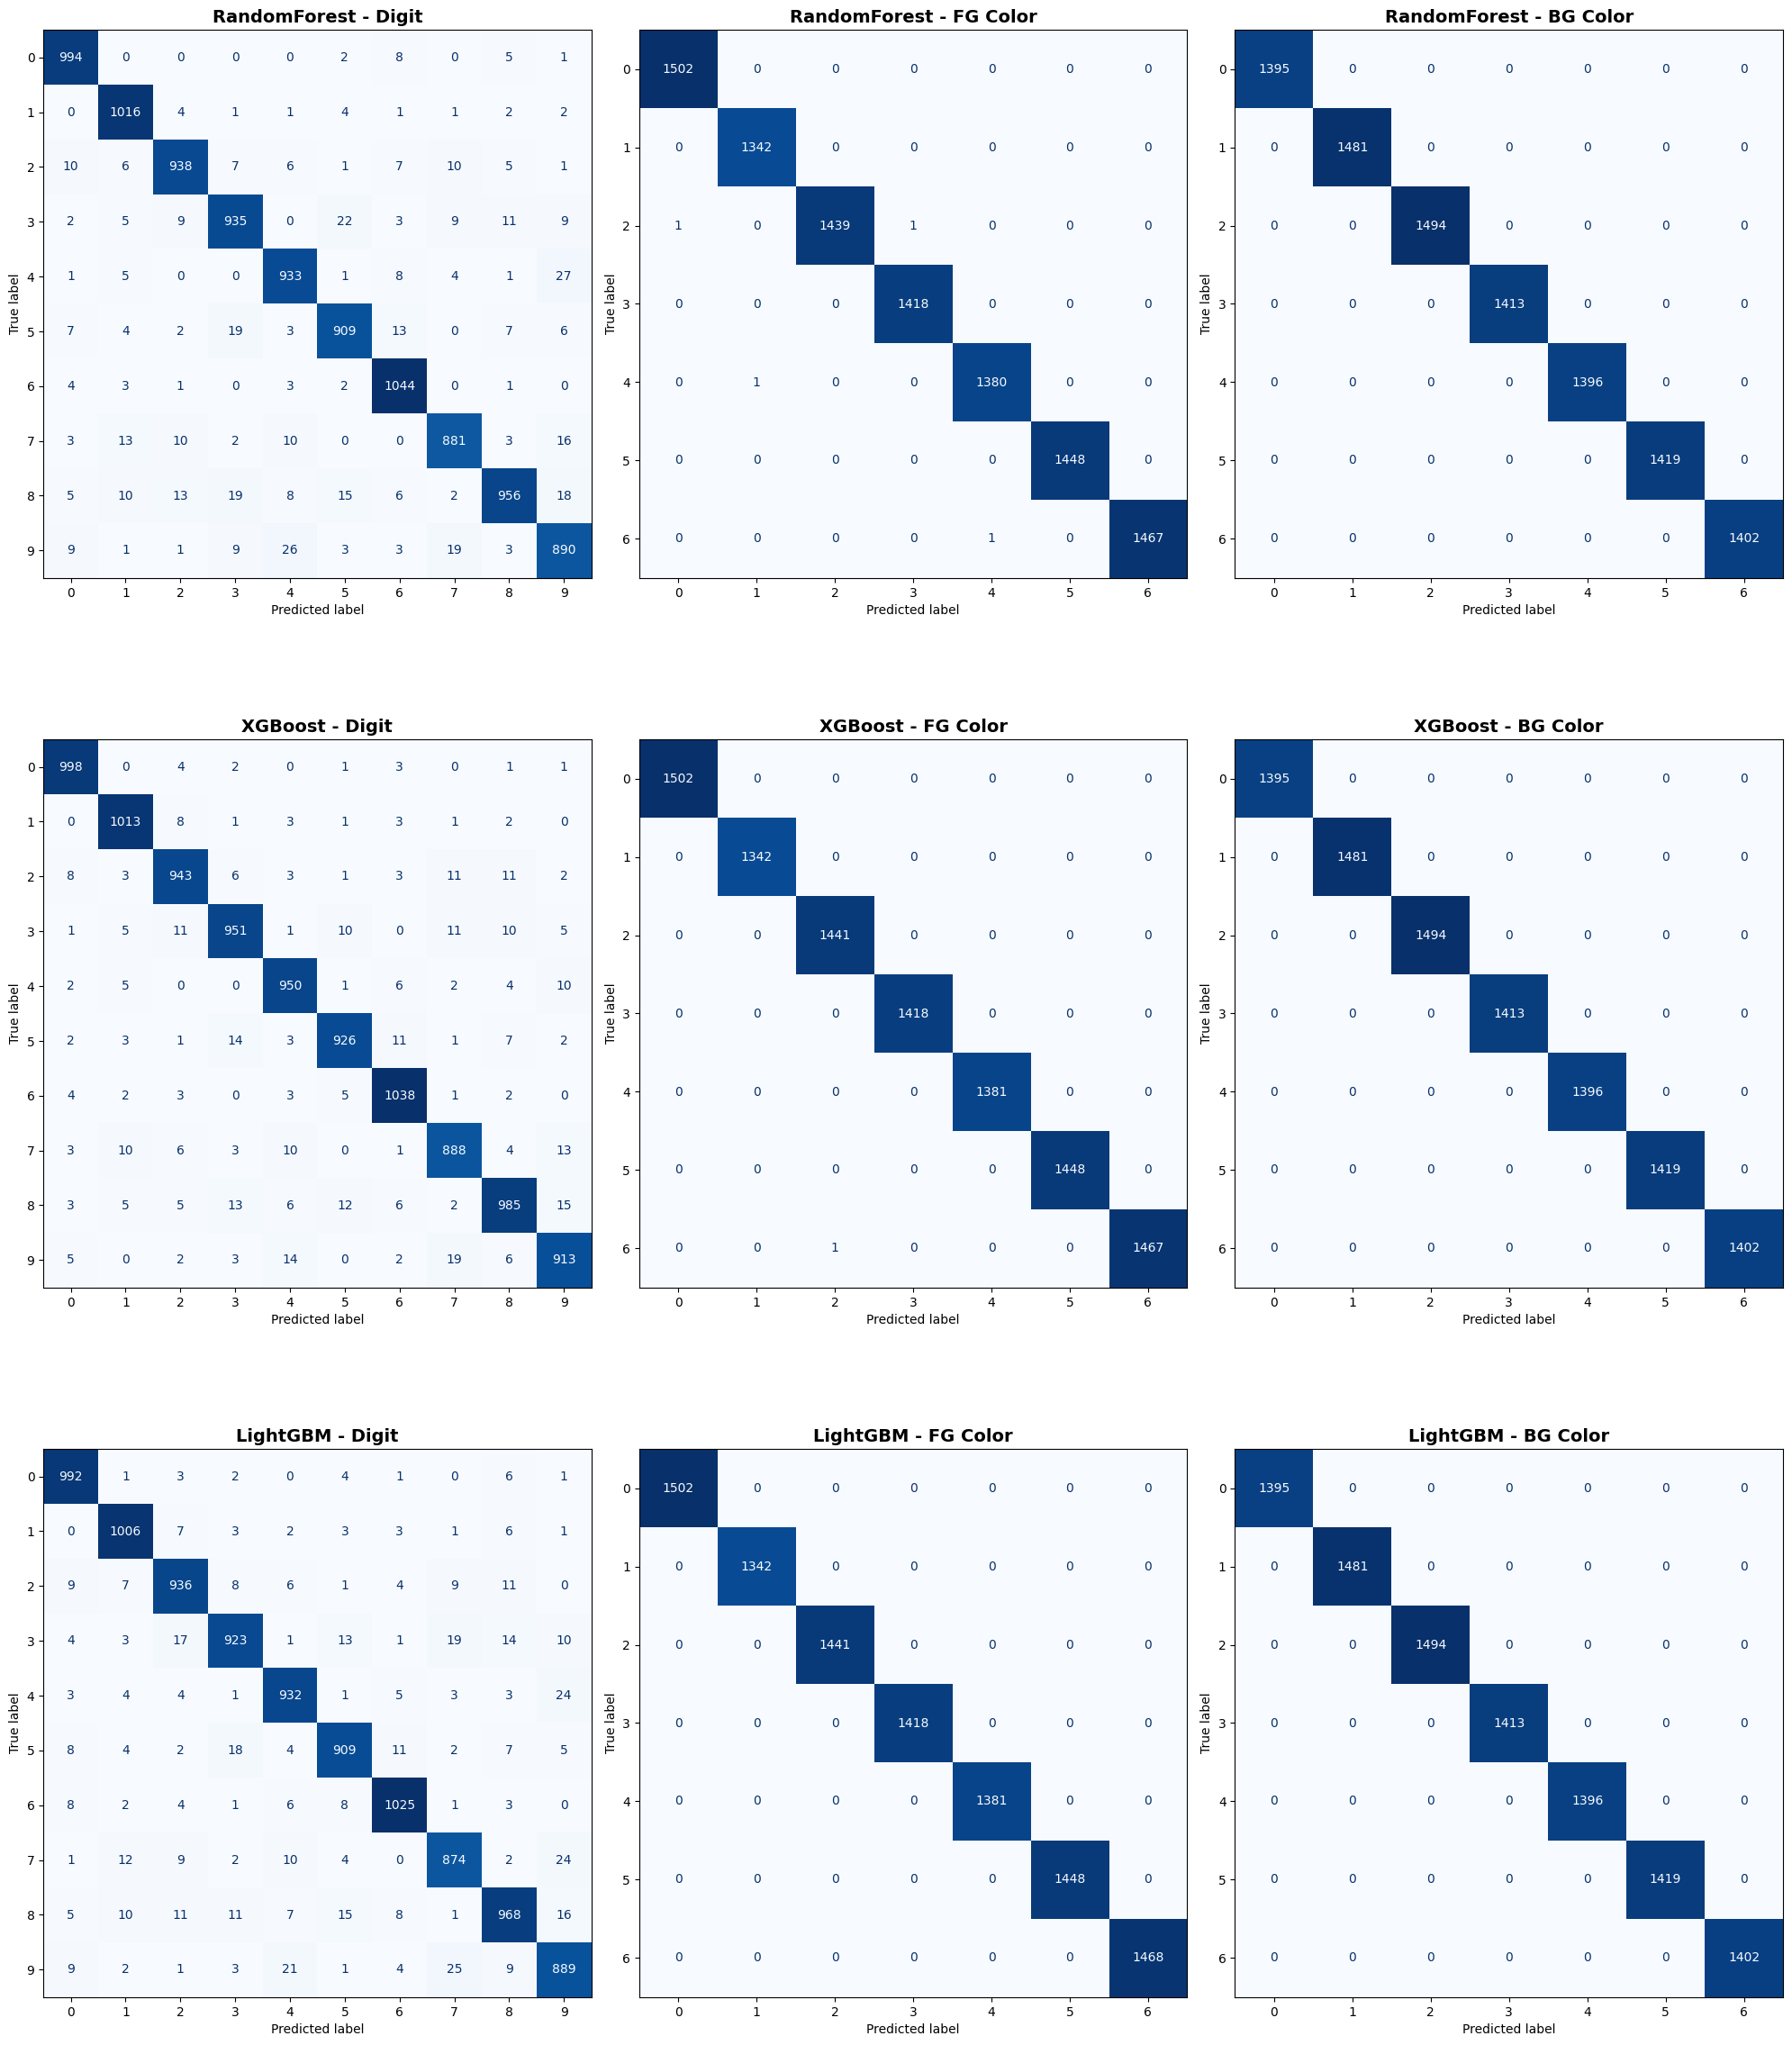

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# 1. 그래프 틀 잡기 (4개 모델 x 3개 태스크 = 12개 서브플롯)
fig, axes = plt.subplots(3, 3, figsize=(20, 24)) # 사이즈는 넉넉하게
axes = axes.flatten() # for문 돌리기 편하게 1차원으로 쫙 펴기

print("--- Confusion Matrix 생성 중 ---")

# 2. 저장된 모델 하나씩 꺼내서 평가하기
# trained_models 딕셔너리에 저장된 순서대로 가져옴
for i, (name, model) in enumerate(trained_models.items()):

    # 현재 모델 이름에 따라 적절한 테스트 데이터 선택 (매칭 룰)
    if "Digit" in name:
        X_val = X_val_flat_color
        y_val = y_val_digit
    elif "FG Color" in name: # 전경색
        X_val = X_val_flat_color
        y_val = y_val_fg
    elif "BG Color" in name: # 배경색
        X_val = X_val_flat_color
        y_val = y_val_bg
    else:
        print(f"Error: {name}에 맞는 데이터를 못 찾겠어!")
        continue

    # 예측 수행
    y_pred = model.predict(X_val)

    # Confusion Matrix 계산
    cm = confusion_matrix(y_val, y_pred)

    # 시각화 (Plot)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    # cmap='Blues': 파란색 계열이 깔끔하고 이뻐.
    # values_format='d': 과학적 표기법(1e2) 말고 정수(100)로 보여줌.
    disp.plot(ax=axes[i], cmap='Blues', values_format='d', colorbar=False)

    # 제목 달기
    axes[i].set_title(f"{name}", fontsize=14, fontweight='bold')

# 레이아웃 깔끔하게 정리
plt.tight_layout()
plt.show()

## 그레이스케일 적용 모델 학습

In [6]:
# 2-2. 숫자 분류용 (Color 3D -> Grayscale 2D -> 1D Flatten)
X_train_gray = np.dot(X_train_color[...,:3], [0.299, 0.587, 0.114])
X_val_gray = np.dot(X_val_color[...,:3], [0.299, 0.587, 0.114])
X_train_flat_gray = X_train_gray.reshape(X_train_gray.shape[0], -1)
X_val_flat_gray = X_val_gray.reshape(X_val_gray.shape[0], -1)

print(f"숫자 분류용 데이터 (Gray): {X_train_flat_gray.shape}")

print("\n--- 3종 모델 학습 시작 ---")

# 학습할 모델과 데이터를 '작업 목록'으로 정의
training_jobs = [
    # 1. RandomForest
    ("RandomForest - Digit", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1), X_train_flat_gray, y_train_digit),

    # 2. XGBoost
    ("XGBoost - Digit", xgb.XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multi:softmax', eval_metric='mlogloss', num_class=NUM_CLASSES_DIGIT), X_train_flat_gray, y_train_digit),

    # 3. LightGBM
    ("LightGBM - Digit", lgb.LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multiclass', num_class=NUM_CLASSES_DIGIT, verbosity=-1), X_train_flat_gray, y_train_digit),
]

# 학습된 모델들을 저장할 딕셔너리
trained_models = {}

# TQDM으로 작업 목록을 감싸서 진행도 표시
for name, model, X_train_data, y_train_data in tqdm(training_jobs, desc="Overall Training Progress"):
    model.fit(X_train_data, y_train_data)
    trained_models[name] = model # 학습 완료된 모델을 이름과 함께 저장

print("\n--- 모든 모델 학습 완료 ---")

숫자 분류용 데이터 (Gray): (80000, 784)

--- 3종 모델 학습 시작 ---


Overall Training Progress: 100%|██████████| 3/3 [08:15<00:00, 165.07s/it]


--- 모든 모델 학습 완료 ---


## 그레이스케일 적용 모델 성능 평가

In [7]:
def evaluate_model(model_name, model_obj):
    print(f"\n===== {model_name} =====")

    # 모델 이름에 따라 올바른 테스트 데이터를 선택
    if "Digit" in model_name:
        X_val, y_val = X_val_flat_gray, y_val_digit

    y_pred = model_obj.predict(X_val)
    y_proba = model_obj.predict_proba(X_val)

    print(classification_report(y_val, y_pred, digits=4))
    auc = roc_auc_score(y_val, y_proba, multi_class='ovr', average='weighted')
    print(f"** Weighted-Average AUC: {auc:.4f} **")

print("\n--- 최종 성능 평가 (Valdation Set) ---")

# 학습된 모델들을 순회하며 평가
for name, model in trained_models.items():
    evaluate_model(name, model)


--- 최종 성능 평가 (Valdation Set) ---

===== RandomForest - Digit =====
              precision    recall  f1-score   support

           0     0.9652    0.9881    0.9765      1010
           1     0.9513    0.9835    0.9671      1032
           2     0.9563    0.9506    0.9534       991
           3     0.9550    0.9294    0.9420      1005
           4     0.9388    0.9551    0.9469       980
           5     0.9452    0.9433    0.9443       970
           6     0.9523    0.9811    0.9665      1058
           7     0.9473    0.9382    0.9427       938
           8     0.9654    0.9030    0.9332      1052
           9     0.9174    0.9212    0.9193       964

    accuracy                         0.9496     10000
   macro avg     0.9494    0.9493    0.9492     10000
weighted avg     0.9497    0.9496    0.9494     10000

** Weighted-Average AUC: 0.9976 **

===== XGBoost - Digit =====
              precision    recall  f1-score   support

           0     0.9602    0.9802    0.9701      1010


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0     0.9429    0.9644    0.9535      1010
           1     0.9507    0.9709    0.9607      1032
           2     0.9227    0.9152    0.9189       991
           3     0.9225    0.9114    0.9169      1005
           4     0.9301    0.9367    0.9334       980
           5     0.9026    0.9175    0.9100       970
           6     0.9438    0.9367    0.9402      1058
           7     0.9198    0.9168    0.9183       938
           8     0.9279    0.9049    0.9163      1052
           9     0.9003    0.8900    0.8951       964

    accuracy                         0.9268     10000
   macro avg     0.9263    0.9265    0.9263     10000
weighted avg     0.9267    0.9268    0.9267     10000

** Weighted-Average AUC: 0.9953 **


--- Confusion Matrix 생성 중 ---


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


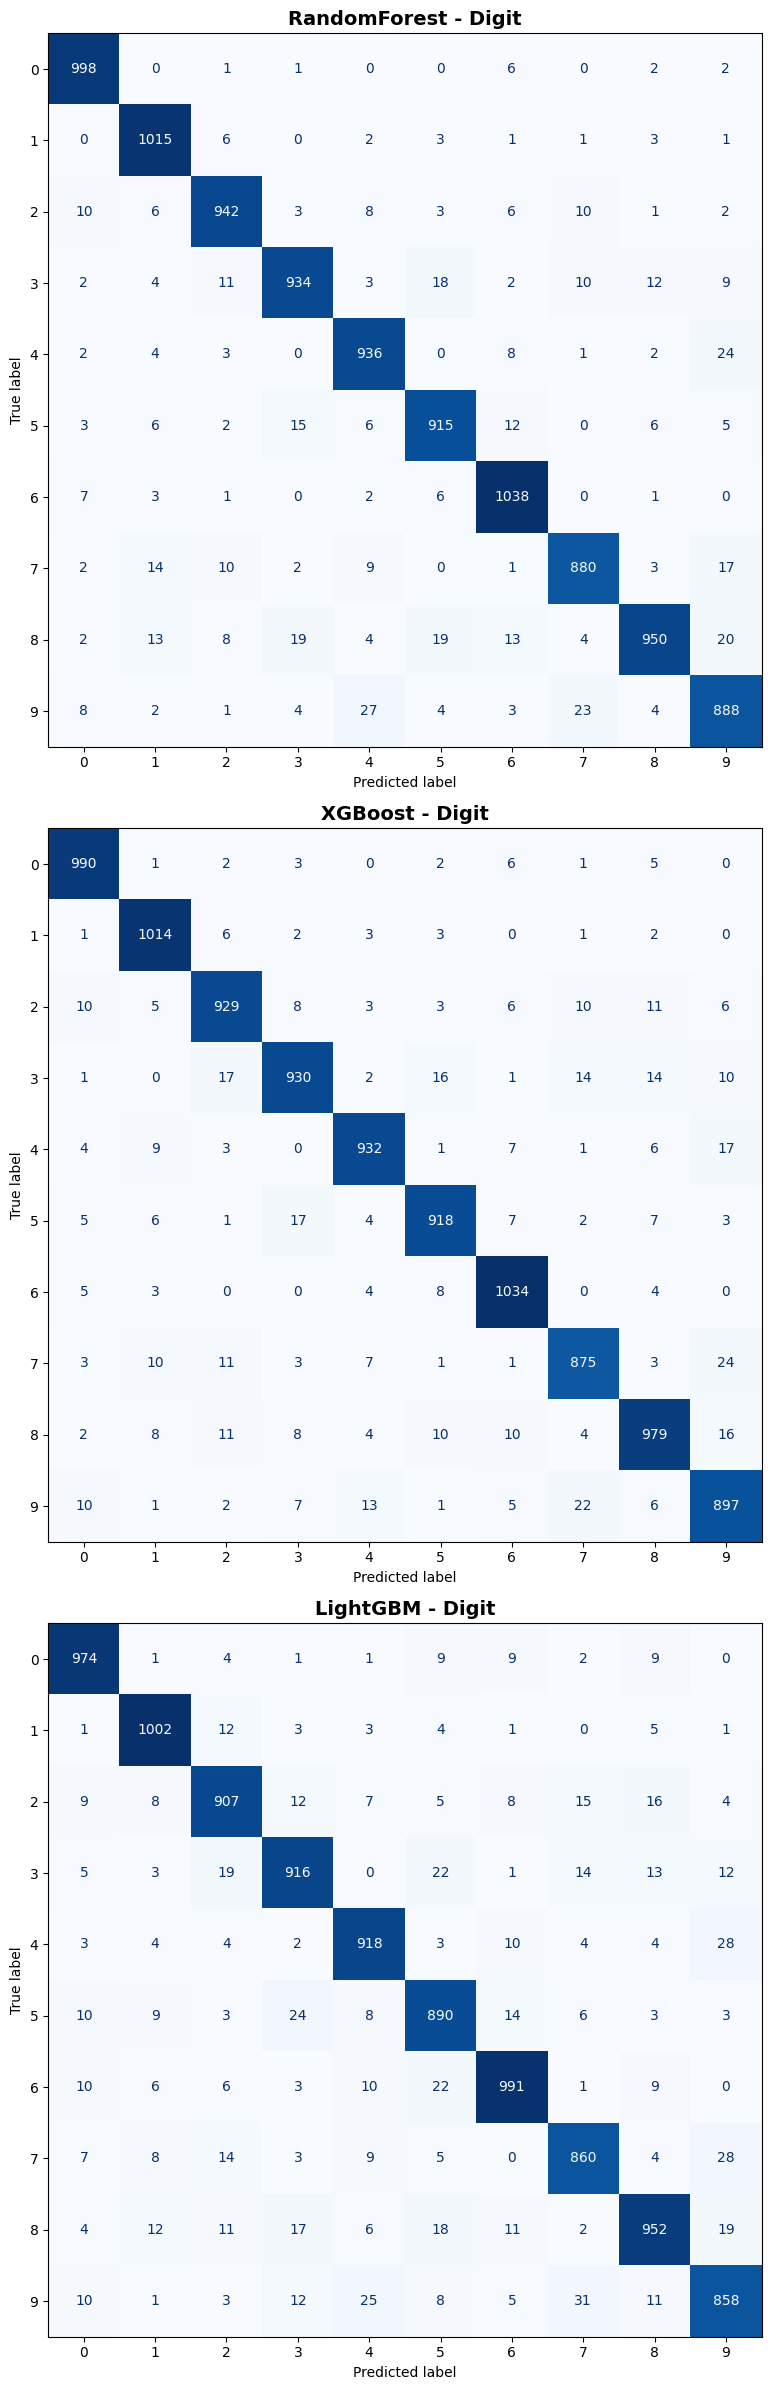

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# 1. 그래프 틀 잡기 (4개 모델 x 3개 태스크 = 12개 서브플롯)
fig, axes = plt.subplots(3, 1, figsize=(20, 24)) # 사이즈는 넉넉하게
axes = axes.flatten() # for문 돌리기 편하게 1차원으로 쫙 펴기

print("--- Confusion Matrix 생성 중 ---")

# 2. 저장된 모델 하나씩 꺼내서 평가하기
# trained_models 딕셔너리에 저장된 순서대로 가져옴
for i, (name, model) in enumerate(trained_models.items()):

    # 현재 모델 이름에 따라 적절한 테스트 데이터 선택 (매칭 룰)
    if "Digit" in name:
        X_val = X_val_flat_gray
        y_val = y_val_digit
    else:
        print(f"Error: {name}에 맞는 데이터를 못 찾겠어!")
        continue

    # 예측 수행
    y_pred = model.predict(X_val)

    # Confusion Matrix 계산
    cm = confusion_matrix(y_val, y_pred)

    # 시각화 (Plot)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    # cmap='Blues': 파란색 계열이 깔끔하고 이뻐.
    # values_format='d': 과학적 표기법(1e2) 말고 정수(100)로 보여줌.
    disp.plot(ax=axes[i], cmap='Blues', values_format='d', colorbar=False)

    # 제목 달기
    axes[i].set_title(f"{name}", fontsize=14, fontweight='bold')

# 레이아웃 깔끔하게 정리
plt.tight_layout()
plt.show()

## HOG 피처 추가 모델 학습

In [9]:
# HOG 파라미터 (이 기본값이 MNIST에 최적화되어 있어)
ppc = 8
cpb = 2

# 학습 데이터에서 HOG 피처 추출
X_train_hog = np.array([hog(image, pixels_per_cell=(ppc, ppc), cells_per_block=(cpb, cpb), visualize=False) for image in tqdm(X_train_gray, desc="학습 데이터 HOG 변환")])

# 테스트 데이터에서 HOG 피처 추출
X_val_hog = np.array([hog(image, pixels_per_cell=(ppc, ppc), cells_per_block=(cpb, cpb), visualize=False) for image in tqdm(X_val_gray, desc="검증 데이터 HOG 변환")])

print(f"HOG 피처 Shape: {X_train_hog.shape}")

# --- 4. HOG 피처로 모델 학습 및 비교 ---
print("\n--- HOG 피처로 최종 모델 학습 시작 ---")

# --- 4-1. RandomForest with HOG ---
print("[1/2] RandomForest 모델 학습 중 (HOG)...")
start_time = time.time()
digit_model_rf_hog = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
digit_model_rf_hog.fit(X_train_hog, y_train_digit)
print(f" -> 학습 완료 (소요 시간: {time.time() - start_time:.2f}초)")

# --- 4-2. XGBoost with HOG ---
print("[2/2] XGBoost 모델 학습 중 (HOG)...")
start_time = time.time()
digit_model_xgb_hog = xgb.XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multi:softmax', eval_metric='mlogloss', num_class=NUM_CLASSES_DIGIT)
digit_model_xgb_hog.fit(X_train_hog, y_train_digit)
print(f" -> 학습 완료 (소요 시간: {time.time() - start_time:.2f}초)")

# --- 4-3. LightGBM with HOG ---
print("[3/3] LightGBM 모델 학습 중 (HOG)...")
start_time = time.time()
digit_model_lgb_hog = lgb.LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multiclass', num_class=NUM_CLASSES_DIGIT)
digit_model_lgb_hog.fit(X_train_hog, y_train_digit)
print(f" -> 학습 완료 (소요 시간: {time.time() - start_time:.2f}초)")

검증 데이터 HOG 변환: 100%|██████████| 10000/10000 [00:01<00:00, 6169.71it/s]


HOG 피처 Shape: (80000, 144)

--- HOG 피처로 최종 모델 학습 시작 ---
[1/2] RandomForest 모델 학습 중 (HOG)...
 -> 학습 완료 (소요 시간: 33.96초)
[2/2] XGBoost 모델 학습 중 (HOG)...
 -> 학습 완료 (소요 시간: 58.60초)
[3/3] LightGBM 모델 학습 중 (HOG)...
 -> 학습 완료 (소요 시간: 27.77초)


## HOG 피처 추가 모델 성능

In [10]:
print("\n--- HOG 모델 최종 성능 평가 (Validation Set) ---")

def evaluate_model_hog(model, model_name, X_val_hog_data, y_val_digit_data):
    print(f"\n===== {model_name} =====")
    y_pred = model.predict(X_val_hog_data)
    y_proba = model.predict_proba(X_val_hog_data)

    print(classification_report(y_val_digit_data, y_pred, digits=4))
    auc = roc_auc_score(y_val_digit_data, y_proba, multi_class='ovr', average='weighted')
    print(f"** Weighted-Average AUC: {auc:.4f} **")

# HOG로 학습된 두 모델의 성능을 나란히 출력
evaluate_model_hog(digit_model_rf_hog, "RandomForest - Digit (HOG)", X_val_hog, y_val_digit)
evaluate_model_hog(digit_model_xgb_hog, "XGBoost - Digit (HOG)", X_val_hog, y_val_digit)
evaluate_model_hog(digit_model_lgb_hog, "LightGBM - Digit (HOG)", X_val_hog, y_val_digit)


--- HOG 모델 최종 성능 평가 (Validation Set) ---

===== RandomForest - Digit (HOG) =====
              precision    recall  f1-score   support

           0     0.9862    0.9921    0.9891      1010
           1     0.9922    0.9913    0.9918      1032
           2     0.9749    0.9798    0.9774       991
           3     0.9748    0.9612    0.9679      1005
           4     0.9779    0.9918    0.9848       980
           5     0.9846    0.9907    0.9877       970
           6     0.9943    0.9905    0.9924      1058
           7     0.9805    0.9648    0.9726       938
           8     0.9671    0.9781    0.9726      1052
           9     0.9812    0.9720    0.9766       964

    accuracy                         0.9814     10000
   macro avg     0.9814    0.9812    0.9813     10000
weighted avg     0.9814    0.9814    0.9814     10000

** Weighted-Average AUC: 0.9997 **

===== XGBoost - Digit (HOG) =====
              precision    recall  f1-score   support

           0     0.9862    0.9921 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0     0.9911    0.9921    0.9916      1010
           1     0.9952    0.9952    0.9952      1032
           2     0.9770    0.9879    0.9824       991
           3     0.9890    0.9801    0.9845      1005
           4     0.9847    0.9867    0.9857       980
           5     0.9908    0.9938    0.9923       970
           6     0.9924    0.9905    0.9915      1058
           7     0.9828    0.9744    0.9786       938
           8     0.9764    0.9848    0.9806      1052
           9     0.9885    0.9813    0.9849       964

    accuracy                         0.9868     10000
   macro avg     0.9868    0.9867    0.9867     10000
weighted avg     0.9868    0.9868    0.9868     10000

** Weighted-Average AUC: 0.9997 **


--- Confusion Matrix 생성 중 ---


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


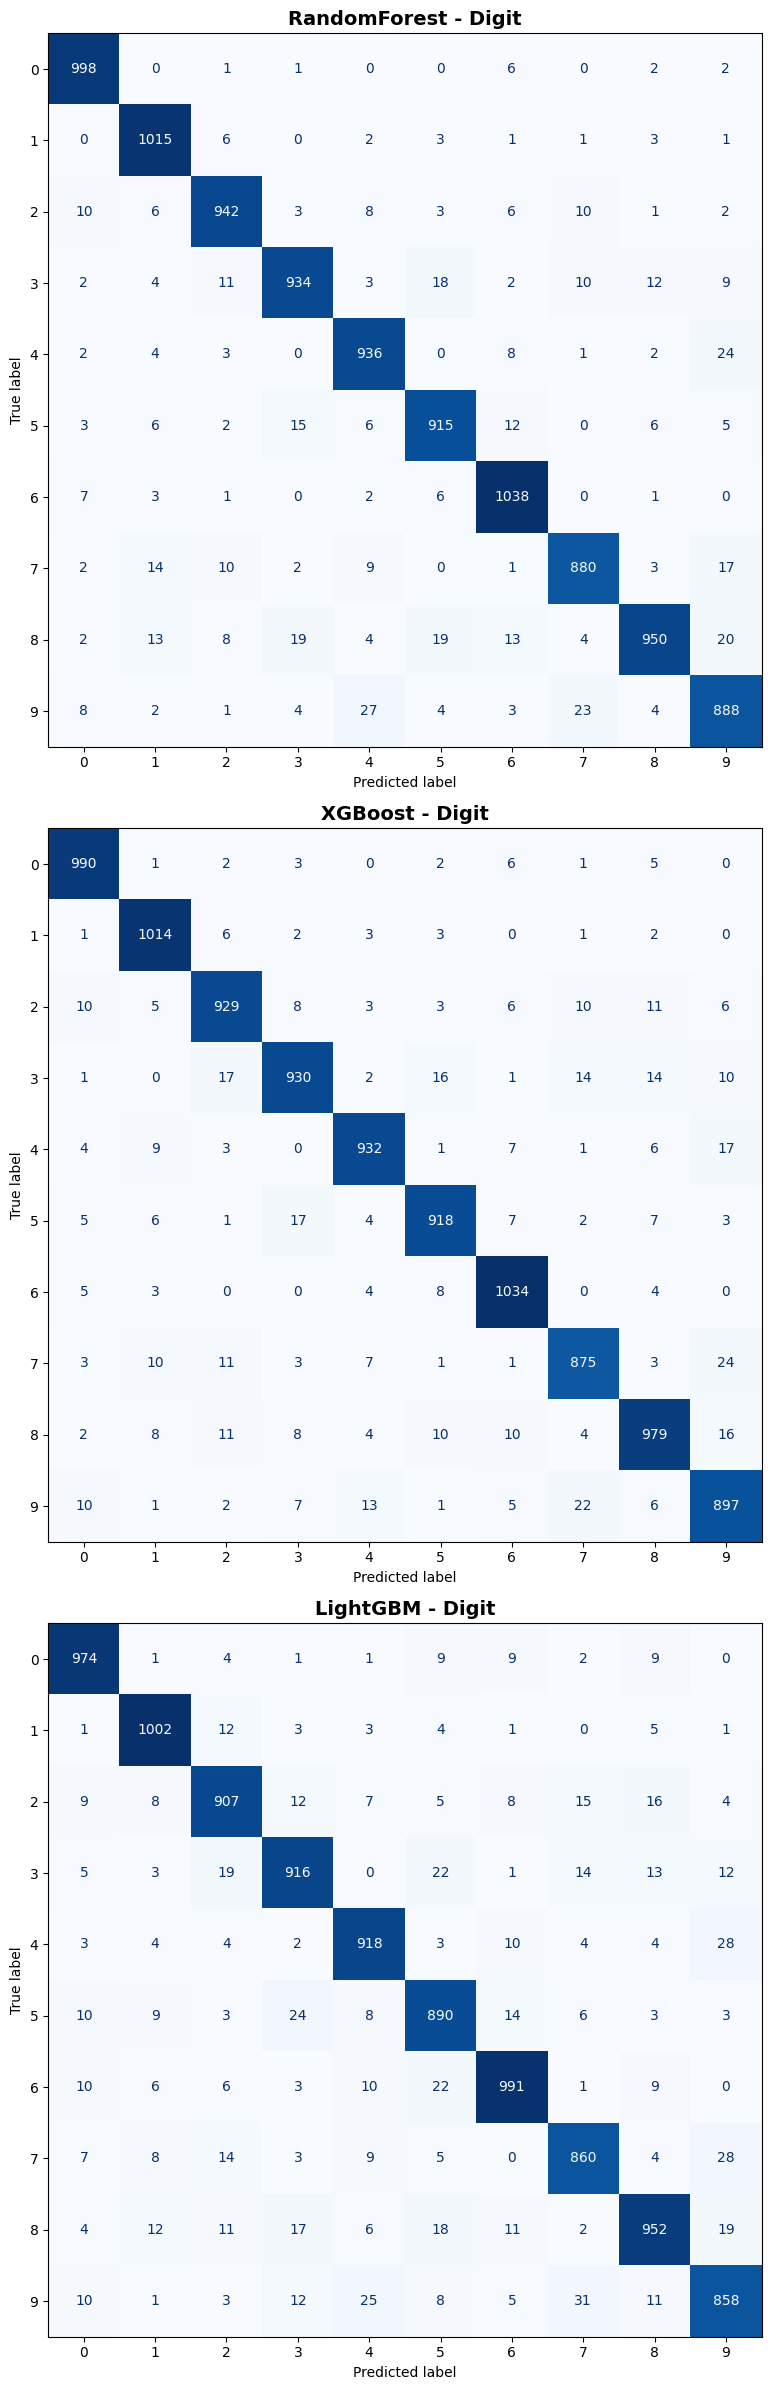

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# 1. 그래프 틀 잡기 (4개 모델 x 3개 태스크 = 12개 서브플롯)
fig, axes = plt.subplots(3, 1, figsize=(20, 24)) # 사이즈는 넉넉하게
axes = axes.flatten() # for문 돌리기 편하게 1차원으로 쫙 펴기

print("--- Confusion Matrix 생성 중 ---")

# 2. 저장된 모델 하나씩 꺼내서 평가하기
# trained_models 딕셔너리에 저장된 순서대로 가져옴
for i, (name, model) in enumerate(trained_models.items()):

    # 현재 모델 이름에 따라 적절한 테스트 데이터 선택 (매칭 룰)
    if "Digit" in name:
        X_val = X_val_flat_gray
        y_val = y_val_digit
    elif "FG Color" in name: # 전경색
        X_val = X_val_flat_color
        y_val = y_val_fg
    elif "BG Color" in name: # 배경색
        X_val = X_val_flat_color
        y_val = y_val_bg
    else:
        print(f"Error: {name}에 맞는 데이터를 못 찾겠어!")
        continue

    # 예측 수행
    y_pred = model.predict(X_val)

    # Confusion Matrix 계산
    cm = confusion_matrix(y_val, y_pred)

    # 시각화 (Plot)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    # cmap='Blues': 파란색 계열이 깔끔하고 이뻐.
    # values_format='d': 과학적 표기법(1e2) 말고 정수(100)로 보여줌.
    disp.plot(ax=axes[i], cmap='Blues', values_format='d', colorbar=False)

    # 제목 달기
    axes[i].set_title(f"{name}", fontsize=14, fontweight='bold')

# 레이아웃 깔끔하게 정리
plt.tight_layout()
plt.show()